# A. Import Essential Libraries

In [1]:
import nltk
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\AppData\Roaming\Python\P

# B. Explore the distribution of the Frauds VS Non-Frauds

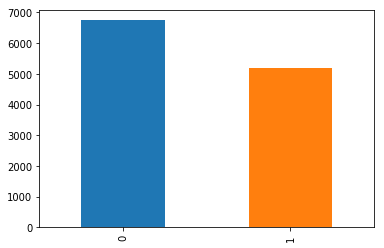

In [2]:
# Let's import the dataset
fraud = pd.read_csv('Frauds.csv')

# It's relatively simple, the email in string format, and an integer (0/1) indicating if it's fraudulent
type(fraud)
type(fraud['Text'][0])
type(fraud['Class'][0])

# Let's convert the 'Class' column to categorical to build our classifier later on
fraud['Text'] = fraud['Text'].astype('category')

# Let's take a look at the distribution of the fraud vs non-fraud emails
fraud['Class'].value_counts().plot(kind='bar') 

## The 2 classes are relatively balanced. 

## <font color = "orange"> If this was not the case, then we'd have to either over-sample the smaller group, or under-sample the larger group, depending on whether we have _sufficiently large number of data points for under-sampling to provide an accurate representation of the larger group_

# C. Perform string tokenization, for removing meaningless stop words in each email, then join back the list into a single string

In [3]:
# Tokenize each email into a discrete list of words
fraud['tokenizedText'] = fraud['Text'].str.split()

# Observe that we've ONE null value in our tokenizedText column
fraud[fraud['tokenizedText'].isnull() == True]

# Observe that we've NO null value in our tokenizedText column
fraud[fraud['Class'].isnull() == True]

# Drop the single row containing NA in tokenizedText
fraud = fraud.dropna()

# Create a set of stopwords to optimize lookup time to O(1)
stopWords = set(stopwords.words('english'))

# Remove the stopwords 
fraud['tokenizedText'] = fraud['tokenizedText'].apply(lambda x: [item for item in x if item not in stopWords])

# Join the words back into a single string
fraud['tokenizedTextCleaned'] = fraud['tokenizedText'].str.join(' ')

# Drop the tokenizedText column
fraud = fraud.drop(axis = 1, columns = 'tokenizedText')

# View the dataframe
fraud.head(n=10)

,Text,Class,tokenizedTextCleaned
0,Supply Quality China's EXCLUSIVE dimensions at...,1,Supply Quality China's EXCLUSIVE dimensions Un...
1,over. SidLet me know. Thx.,0,over. SidLet know. Thx.
2,"Dear Friend,Greetings to you.I wish to accost ...",1,"Dear Friend,Greetings you.I wish accost reques..."
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....
4,Not a surprising assessment from Embassy.,0,Not surprising assessment Embassy.
5,Monica -Huma Abedin <Huma@clintonemail.com>Tue...,0,Monica -Huma Abedin <Huma@clintonemail.com>Tue...
6,Pis print.H <hrod17@clintonemail.com>Thursday ...,0,Pis print.H <hrod17@clintonemail.com>Thursday ...
7,Dear Tom--H <hrod17@clintonemail.com>Friday De...,0,Dear Tom--H <hrod17@clintonemail.com>Friday De...
8,Greetings from barrister Robert Williams=2CDea...,1,Greetings barrister Robert Williams=2CDear fri...
9,FYI. Thanks again for signing the book ---- an...,0,FYI. Thanks signing book ---- I hope get royal...


# <font color = "orange"> Observe how many meaningless words have been removed from the text

# D. Perform a basic train-test split and apply a simple logistic regression model on it

In [4]:
# Create a train-test split for the dataset
X = fraud['tokenizedTextCleaned']
y = fraud['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# <font color = "orange"> I've chosen to keep things very simple here, just to illustrate the idea
# <font color = "orange"> We could've instead used a K-Fold Cross Validation if we wish to:
## 1) Prevent overfitting (low bias (ie. very accurate on average) high variance models), which is especially common on high-dimensional datasets like our TF-IDF matrix later, since every single word is mapped as a feature for our logistic regresion to train on
## 2) Wanted to tune the hyperparameters without using another validation set - this will further drop our training dataset size

# E. We've to first pre-process our cleaned email strings via 3 steps:
## 1) Convert the strings into a COUNT MATRIX, where every feature/column heading refers to a particular word, and each cell contains the word frequency in the string (ie. each document) <br>
## 2) We then convert this Count Matrix into a TF-IDF Matrix (TF * IDF)

# <font color = "orange"> Key Concept : Count Matrix ---> TF-IDF Matrix
### (1) Term Frequency (Higher = More relevant word = More weight attached to it)
### (a) Refers to the RELATIVE frequency that a word shows up in a PARTICULAR DOCUMENT (ie. email)
### (b) This helps to take document size (ie. email length) out of the equation, this is similar to Standard Scaling (ie. normalizing) our numerical features (eg. AGE, INCOME) to avoid large absolute values from being considered as overly important during model fitting <br>

### (2) Inverse Document Frequency (tells us how SPECIFIC the word is. The more specific it is to a document/email, the more weight we attach to it when calculating IDF values)
### (a) Refers to the logarithm of the INVERSE of the term frequency across ALL DOCUMENTS (ie. all emails)

In [8]:
# Our preprocessing pipeline is :
logreg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression()),
                  ])

# Fit the logistic regression model
logreg.fit(X_train, y_train)

# Fit and predict on the testing set
y_pred = logreg.predict(X_test)
print('Logistic Regression Model')
print('Accuracy : %s' % accuracy_score(y_pred, y_test))
print('AUC : %s' % roc_auc_score(y_pred, y_test))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print()

# Check the False Negative Rate (this refers to the percentage of FRAUDULENT emails that our classifier FAILED TO CATCH)
print('FNR = {0:.2f}%'.format(confusion_matrix(y_test, y_pred)[1][0] / sum(sum(confusion_matrix(y_test, y_pred))) * 100))


Logistic Regression Model
Accuracy : 0.9823973176865046
AUC : 0.9846152002760666

Confusion Matrix
[[1997    1]
 [  62 1519]]

FNR = 1.73%


# <font color = 'orange'> That's weird... basic logistic regression models shouldn't have this kind of accuracy on high-dimensional text classification datasets like this. Head back to Kaggle to check other people's works : https://www.kaggle.com/llabhishekll/fraud-email-dataset/kernels

# Accuracy is pretty horrible for assessing a classifier, we instead use a ROC for general evaluation, where the Area Under Curve (AUC) can be evaluated

# Also, FNR seems to me to be the most important in assessing how good our classifier is. Ideally, FNR should be 0 to minimize losses to SocGen

# <font color = "orange"> Hence, note the dangerous 62 False Negatives (fraud emails classified as SAFE) that we have which could potentially lead to expensive data breaches
    
# <font color = "orange"> SOLUTION??? Simply lower the classifier's cutoff from the default 50% that is set. COMPROMISE??? We'll probably get a lot of false alarms. If we choose to rely on it, a SIMPLE WARNING can be presented to employees, instead of choosing to send the email straight to Spam/Trash, as we don't want to delete important client emails that were incorrectly flagged.

# <font color = "orange"> F. Can we do better? Considering information leaks from investment banks could potentially cost millions in lost revenue or lawsuit damages, can we develop a better model?

### Let's now try a RANDOM FOREST CLASSIFIER, which tends to avoid the pitfalls of overfitting in extremely high-dimensional datasets like this

In [9]:
# Our preprocessing pipeline is :
rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier()),
               ])

# We perform GridSearch during the CV Process to tune the model's hyperparameters as we train it
# Let's just focus on the 3 most important ones, otherwise training on a regular PC will take too long 
n_estimators = [500, 1000]
max_depth = [50, 100]
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'clf__n_estimators': n_estimators,
               'clf__max_depth': max_depth,
               'clf__min_samples_split': min_samples_split}

# Start the Randomized Grid Search
grid_search = RandomizedSearchCV(estimator = rfc,  param_distributions = random_grid, 
                                 n_iter = 3, cv = 2, n_jobs = -1, verbose = 0)

# Fit the RFC model
grid_search.fit(X_train, y_train)

# Fit and predict on the testing set
y_pred = grid_search.predict(X_test)
print('Random Forest Classification Model')
print('Accuracy : %s' % accuracy_score(y_pred, y_test))
print('AUC : %s' % roc_auc_score(y_pred, y_test))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print()

# Check the False Positive Rate (this refers to the percentage of FRAUDULENT emails that our classifier FAILED TO CATCH)
print('FNR = {0:.2f}%'.format(confusion_matrix(y_test, y_pred)[1][0] / sum(sum(confusion_matrix(y_test, y_pred))) * 100))


Random Forest Classification Model
Accuracy : 0.9804414640961162
AUC : 0.9819033382841333

Confusion Matrix
[[1986   12]
 [  58 1523]]

FNR = 1.62%


# <font color = 'orange'> Well, we did a little better on this... but still, due to a lack of computational power on my PC, we weren't able to exhaustively search a larger search space for our hyperparameters quickly, to yield an even better model with a lower FNR.
    
# Usual Steps :
1) Perform a Random Search on many different hyperparameter combinations <br>
2) Once the best has been selected, we narrow the combination range in the tuning grid <br>
3) Apply this more specific tuning grid and perform an exhaustive Grid Search to go through EACH POSSIBLE COMBINATION <br>

# G. Final Thoughts & Possible Improvements
## <font color = 'orange'> 1. Applying PCA to counter over-fitting on high-dimensional TF-IDF Matrix 
1) N-features = N-dimensions <br><br>
2) Assume 2 features, hence 2 dimensions <br><br>
3) In 2D Space : Think of PCA as a "best-fit line" through the points, and this line will now become the principal component, PC1, which explains for the largest variance (ie. scattering) of the points. This is also known as the eigenvector in PCA, and corresponds to a COMPLETELY NEW "VARIABLE", from a linear combination (eg X+Y) of the original 2 variables, X and Y. <br><br>
4) We then draw a perpenticular to this eigenvector, PC2, which consequently accounts for the LEAST variation in the dataset, and hence can be dropped. <br><br>

## <font color = 'orange'> 2. L1 regularization (to reduce overfitting on high dimensional datasets), which is extremely suitable for sparse vectors, such as the TF-IDF matrix we're running our classification algorithm on. L1 will completely remove the features/words that are not that important (ie. smallest TF-IDF values), whereas L2 will simply scale them down
    
## <font color = 'orange'> 3. Perform over-sampling (either through simply repeating points, or to apply clustering algorithms to generate SIMILAR SYNTHETIC DATA POINTS IN THE TF-IDF MATRIX for the smaller dataset) of the smaller dataset 
    
## <font color = 'orange'> 4.Depending on the importance of FPR vs FNR, we can tweak our classifier's cutoff to focus on MINIMIZING ONE. My guess is FNR is much more detrimental to SocGen in terms of potential losses incurred.
    
## <font color = 'orange'> 4.Depending on the importance of FPR vs FNR, we can tweak our classifier's cutoff to focus on MINIMIZING ONE. My guess is FNR is much more detrimental to SocGen in terms of potential losses incurred.
    
## <font color = 'orange'> 5. I believe MLP classifiers will hit over 99% accuracy even on testing dataset. However, it can be very easy to overfit the training data if appropriate dropout layers aren't added when constructing the neural net, and also it is extremely data-hungry, which shoudln't be a problem for big banks like yourself, but smaller banks who wish to implement such a system will find it difficult.

# H. Questions for SocGen 

1. @ Ricky : As a IT Fraud Manager, are these traditional ML models still used extensively, or have neural nets dominated the industry? It seems like everyone everywhere is using all these deep learning methods, do you think there is still a place for traditional ML models like the ones I used in this project?

2. Are the models that I've developed in this script too simple for use in real life? What kind of improvements should I make in making them better?

3. May I know what was it about me that made you want to interview me today?